In [234]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt

from cube_fil_finder.util import cube_util
from cube_fil_finder.galfa import preprocess_cube, galfa_util

import pickle 
from cube_fil_finder.util import moments
import random
import astropy.units as u
from cube_fil_finder.util import cube_util
from astropy.io import fits

from fil_finder import FilFinder2D, Filament2D
from fil_finder.tests.testing_utils import generate_filament_model
import mask_obj_node as maskNode
from cube_fil_finder.structs import util as struct_util
from cube_fil_finder.util import moments
from cube_fil_finder.util import tree_dict_util 
from cube_fil_finder.structs import mask_obj_node_tree as maskTree
from cube_fil_finder.structs import util as struct_util

reload(tree_dict_util)

%matplotlib inline

In [170]:
test_fits_path = '../../debug/avery_test_cube/inject_test_with_injection.fits'
test_fits_path = os.path.abspath(test_fits_path)

In [171]:
fits_data, header = fits.getdata(test_fits_path, header=True)

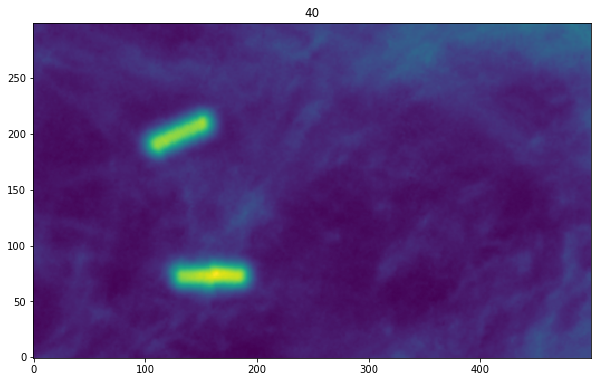

In [257]:
for i in range(40, 41):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(fits_data[i], origin='lower')
    ax.set_title(i)

In [173]:
def construct_filaments(vslice, header, v_channel):
    """
    Find a filamentary structure at a given velocity slice.
    
    Returns:
    node of masked objects (for the purpose of checking overlaps)
    """
    header['BUNIT'] = 'K' # to be read by astropy.units
    scale_width = 0.1 * u.pc # empirical 
    filament = FilFinder2D(vslice, header=header, distance=100.*u.pc, beamwidth=10.*u.arcmin)
    filament.preprocess_image(flatten_percent=95)
    filament_masks, corners = filament.create_mask(smooth_size = scale_width/2, adapt_thresh=scale_width*2, 
                         size_thresh= 8*(scale_width*2)**2, border_masking=False, output_mask_objs=True)
    
    nmasks = len(filament_masks)
    
    node_dict = {}
    if filament_masks is None:
        pass
    else:
        for i in range(nmasks):
            mask_node = maskNode.MaskObjNode(filament_masks[i], corners[i], v_channel)
            struct_util.add_node_to_dict(mask_node, node_dict)
    
    return node_dict

def noderun_for_multichannel_modified(valid_slices, header, save_path=None):
    """
    Run for multiple velocity slices
    """
    all_nodes = {}
    nch = len(valid_slices) ## number of velocity slices
    for i in range(nch):
    #for i in range(nch, 0, -1): ## reverse test
        node_one = construct_filaments(valid_slices[i], header, i)
        all_nodes[i] = node_one
    return all_nodes

def find_trees(nodes, overlap_thresh=.85, reverse_find=False):
    """
    Find trees from nodes
    """
    trees = {} ## individual tree
    connected_trees = set()
    
    vindex = nodes.keys() ## it is a list of velocity indices of a given node
    nchannel = len(vindex)
    
    for i in range(nchannel):
        current_node = nodes[vindex[i]]
        filaments = tree_dict_util.struct_util.sorted_struct_dict_keys_by_area(current_node, 'node')
        for j in filaments:
            mode = current_node[j]
            oldflag = tree_dict_util.match_and_add_node_onto_tree(mode, vindex[i], trees, overlap_thresh, continuous_trees=connected_trees)
            if not oldflag: # if tree is empty raise
                new_tree = maskTree.newTreeFromNode(mode, verbose=False)
                struct_util.add_tree_to_dict(new_tree, trees)
                
        connected_trees = tree_dict_util.end_noncontinuous_trees(trees, vindex[i])
        #tree_dict_util.delete_short_dead_trees(trees, verbose=False)
    
    return trees


def process_filaments(vslices, hdr, wkernel=15, overlap=0.85, usm_return=True):
    """
    Find filaments
    """
    usmed = np.zeros_like(vslices)
    for i in range(len(vslices)):
        usmed[i] = cube_util.umask(vslices[i], wkernel)
    
    nodes = noderun_for_multichannel_modified(usmed, hdr)
    pre_trees = find_trees(nodes, overlap_thresh=overlap)
    trees = filter_trees(pre_trees) # require length>2
    if usm_return is True:
        return trees, usmed
    else:
        return trees
        

def ordering_corners(corner):
    """
    Just place ordering in the right place for extent plotting
    """
    aligned = [corner[0][1], corner[1][1], corner[0][0], corner[1][0]]
    return aligned

In [174]:
data_subset = fits_data
usmed_data = np.zeros_like(data_subset)
for i in range(data_subset.shape[0]):
    usmed_data[i] = cube_util.umask(data_subset[i])

In [175]:
nodes_dicts = dict()
for v in range(usmed_data.shape[0]):
    nodes_dicts[v] = preprocess_cube.process_dataslice_filfind_struct(usmed_data[v], header, v)

In [176]:
#[len(d) for k, d in nodes_dicts.items()]

In [177]:
# filter out nodes on the boundaries
nodes_dicts_clean = dict()
for v in nodes_dicts:
    nodes_dicts_clean[v] = {k: v for k, v in nodes_dicts[v].items()
                            if not(v.corners[0][0] <= 10
                                   or v.corners[0][1] <= 10
                                   or v.corners[1][0] >= 290
                                   or v.corners[1][1] >= 490)}

In [178]:
trees = find_trees(nodes_dicts_clean)
for k in trees:
    trees[k].has_ended = True
tree_dict_util.delete_short_dead_trees(trees, size_cutoff=400)

corners don't overlap!!!
corners don't overlap!!!
corners don't overlap!!!


In [146]:
len(trees)

344

(array([  0.,   0.,  76.,  42.,  19.,  21.,   9.,   9.,  10.,   5.,   2.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   2.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

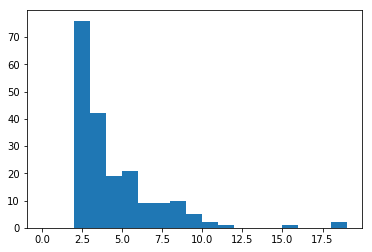

In [181]:
lengths = [v.length for k, v in trees.items()]
plt.hist(lengths, bins=np.arange(0, 20))

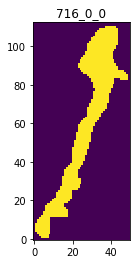

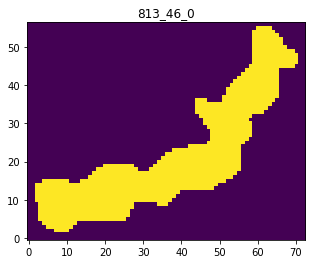

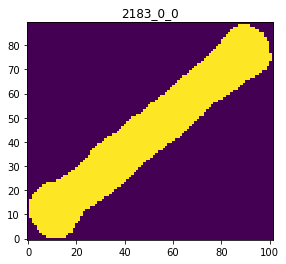

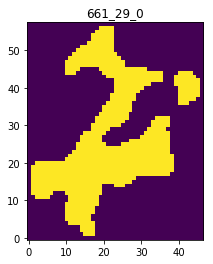

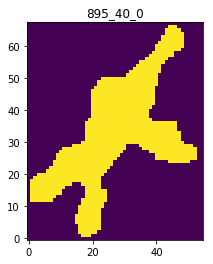

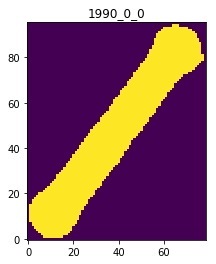

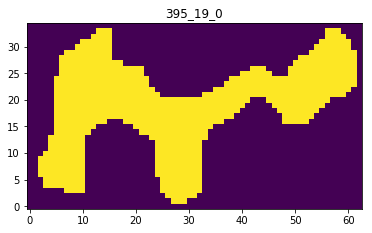

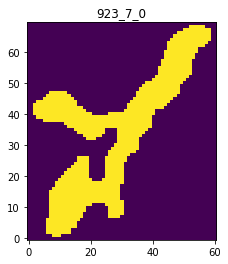

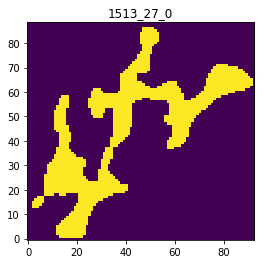

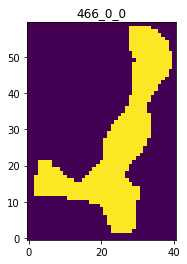

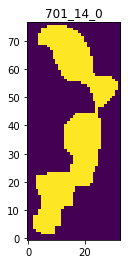

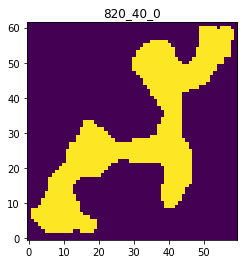

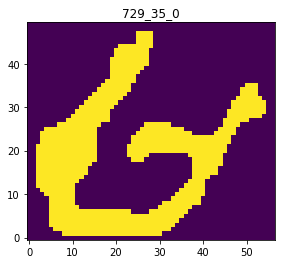

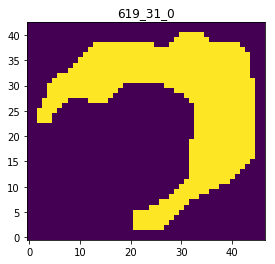

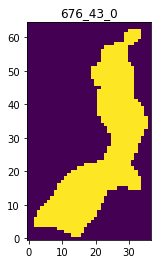

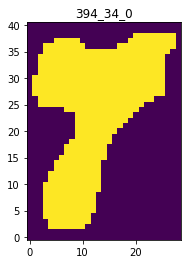

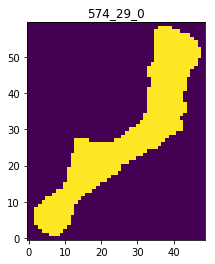

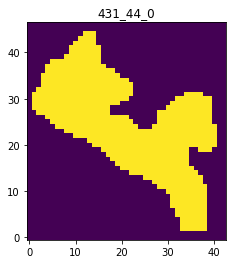

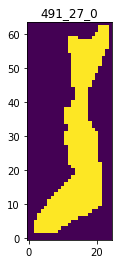

In [189]:
for k, v in trees.items():
    if v.length == 4:
        fig, ax = plt.subplots()
        ax.imshow(v.root_node.mask, origin='lower')
        ax.set_title(k)

In [200]:
def vis_channel_maps(plot_data, plot_mask_data, plot_mask_corners, key, pre_pad=0, post_pad=0):
    fig, axs = plt.subplots(len(plot_data), 1, figsize=(4, 24))

    min_val, max_val = np.min(plot_data), np.max(plot_data)
    min_cut, max_cut = np.percentile(plot_data, 5), np.percentile(plot_data, 95)

    ra, dec = galfa_util.galfa_index_to_radecs([plot_mask_corners[0][1], plot_mask_corners[1][1]],
                                               [plot_mask_corners[0][0], plot_mask_corners[1][0]])
    pad_slices = pre_pad + post_pad
    plot_mask_slices = [np.arange(pre_pad, )]
    for i, ax in enumerate(axs):
        plot_data[i, 0, 0] = min_cut
        plot_data[i, 0, 1] = max_cut
        ax.imshow(plot_data[i].clip(min_cut, max_cut), origin='lower', cmap='binary')

        
        if i >= pre_pad and i < len(data) - post_pad:
            ax.contour(plot_mask_data, alpha=.5, colors='red', linewidths=.3)

        ax.set_xlabel('RA')
        ax.set_ylabel('DEC')

        ax.set_yticks([0, plot_mask_corners[1][0]-plot_mask_corners[0][0]])
        ax.set_yticklabels(np.round(dec,2))
        ax.set_xticks([0, plot_mask_corners[1][1]-plot_mask_corners[0][1]])
        ax.set_xticklabels(np.round(ra,2))
        ax.set_title('{0} ({1})'.format(key, i-2))

    fig.tight_layout()
    fig.show()

In [201]:
short_trees = {k: v for k, v in trees.items() if v.length == 3}

In [202]:
ex_trees = {k: v for k, v in short_trees.items() if random.random() < .1}

In [227]:
ex_trees = {k: v for k, v in trees.items() if k == '2183_0_0'}

4
(6, 90, 102)


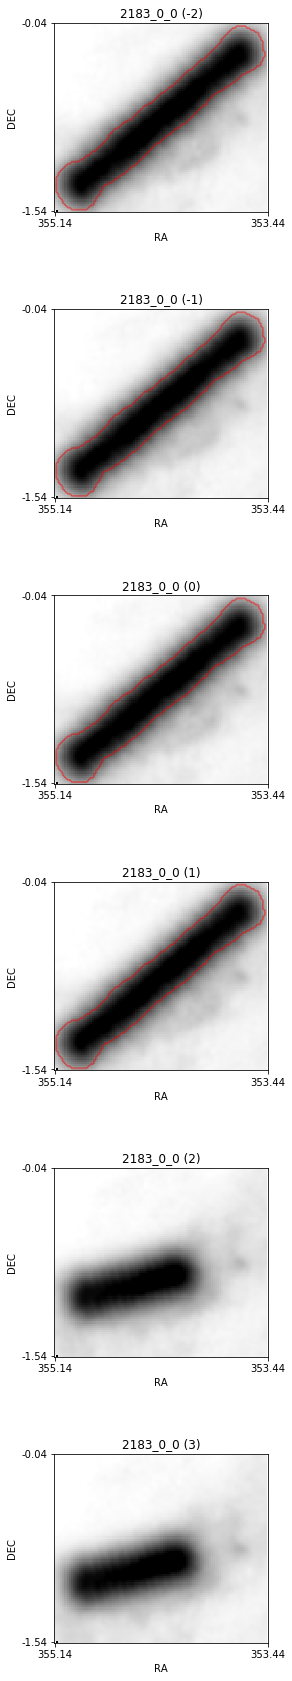

In [230]:
for k, tree in ex_trees.items():
    r_mask = tree.root_node.mask
    corners = tree.root_node.corners
    v_0 = tree.root_v_slice
    print(tree.length)
    v_f = v_0 + tree.length
    pre_pad = 0
    post_pad = 2
    data = fits_data[v_0 - pre_pad: v_f + post_pad,
                     corners[0][0]: corners[1][0],
                     corners[0][1]: corners[1][1]]
    print(data.shape)
    vis_channel_maps(data, r_mask, corners, k, pre_pad=pre_pad, post_pad=post_pad)

# investigation!!!

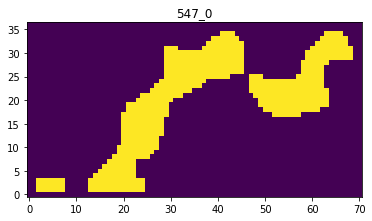

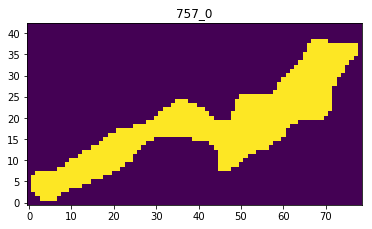

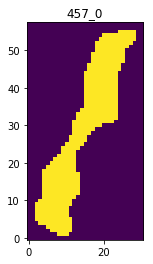

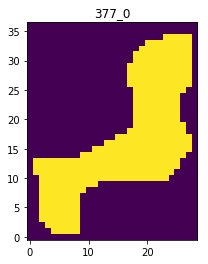

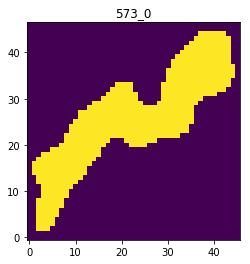

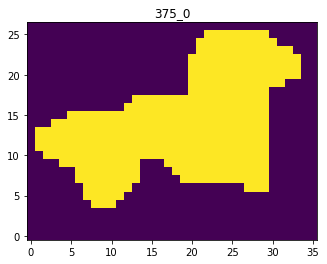

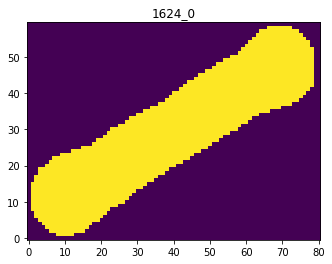

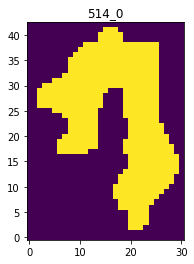

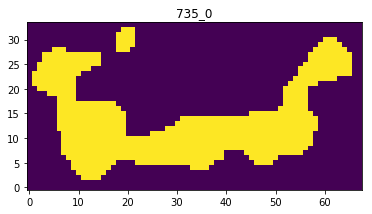

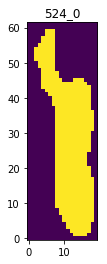

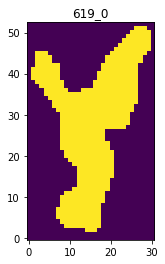

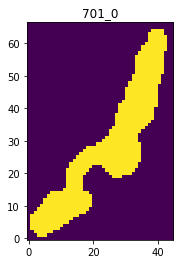

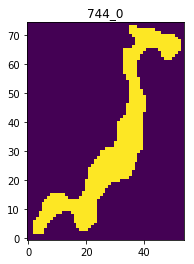

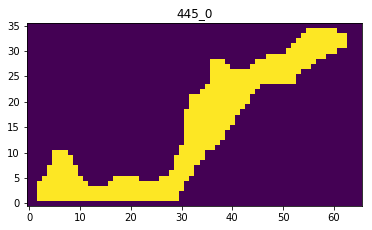

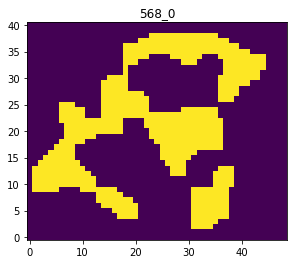

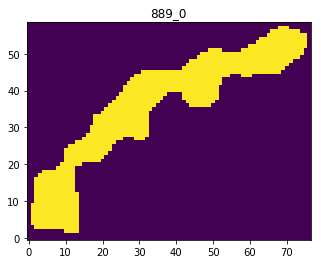

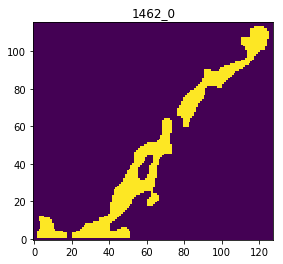

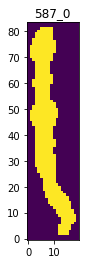

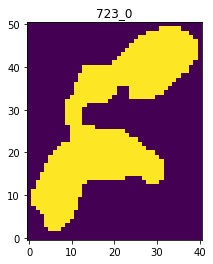

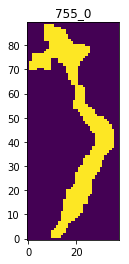

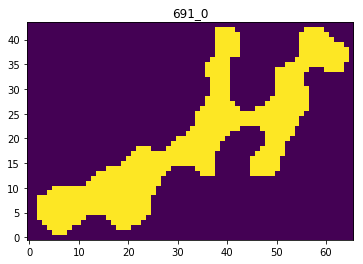

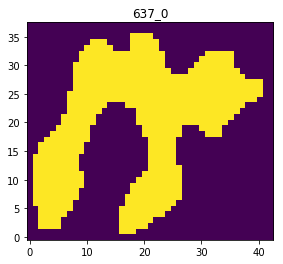

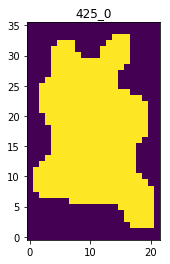

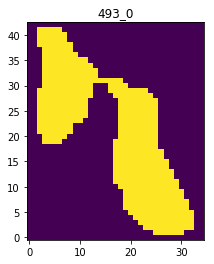

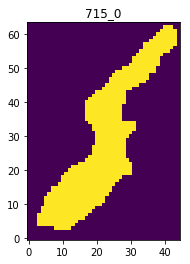

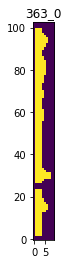

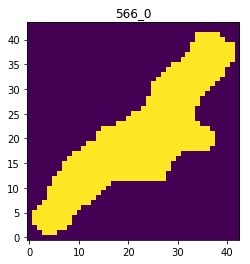

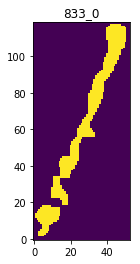

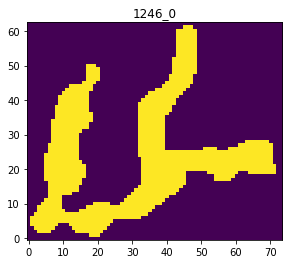

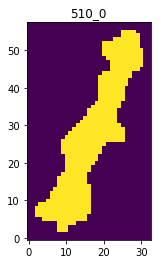

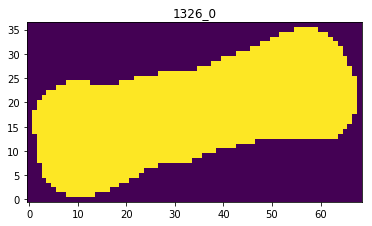

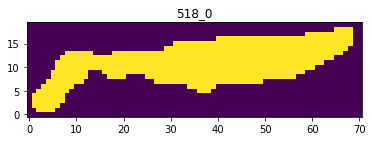

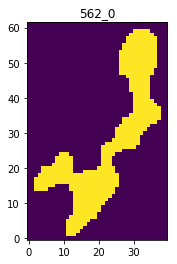

In [215]:
for k, v in nodes_dicts[4].items():
    fig, ax = plt.subplots()
    ax.imshow(v.mask, origin='lower')
    ax.set_title(k)

In [217]:
inv_nodes_dicts = dict()
inv_nodes_dicts[0] = {'1990_0': nodes_dicts[0]['1990_0']}
inv_nodes_dicts[1] = {'1995_0': nodes_dicts[1]['1995_0']}
inv_nodes_dicts[2] = {'1996_0': nodes_dicts[2]['1996_0']}
inv_nodes_dicts[3] = {'1991_0': nodes_dicts[3]['1991_0']}

In [218]:
inv_nodes_dicts

{0: {'1990_0': <mask_obj_node.MaskObjNode instance at 0x11c0d6320>},
 1: {'1995_0': <mask_obj_node.MaskObjNode instance at 0x1193f8050>},
 2: {'1996_0': <mask_obj_node.MaskObjNode instance at 0x1183ca998>},
 3: {'1991_0': <mask_obj_node.MaskObjNode instance at 0x111c7f488>}}

In [219]:
inv_trees = find_trees(inv_nodes_dicts)

In [222]:
inv_trees

{'1990_0_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1151dc950>}

In [224]:
inv_trees['1990_0_0'].length

4

# investigation 2!!!

In [246]:
starts = [0,4,7,13,16,23,30,32,40,45]

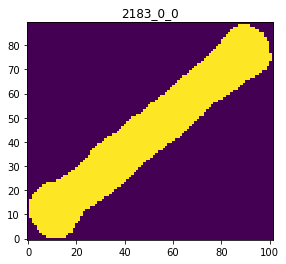

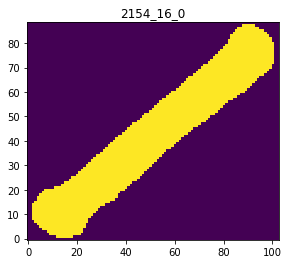

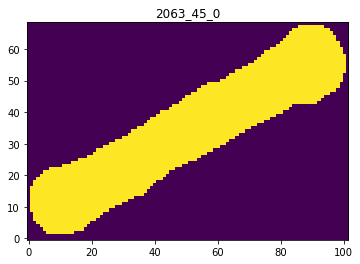

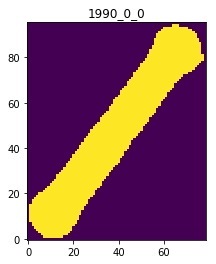

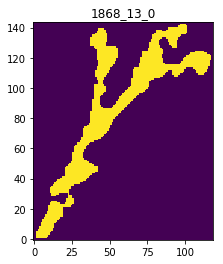

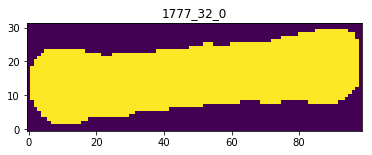

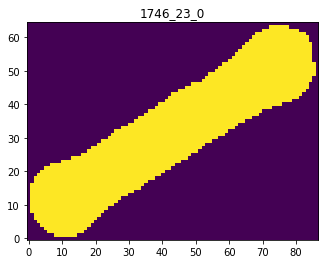

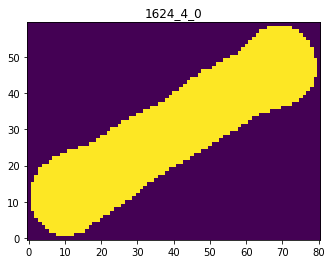

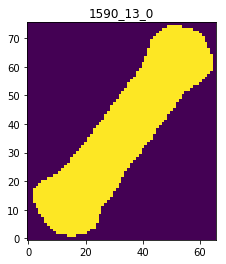

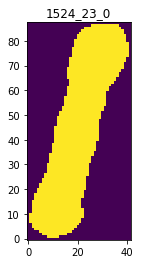

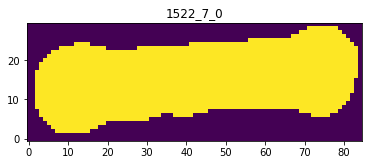

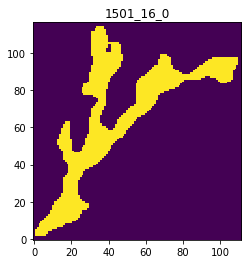

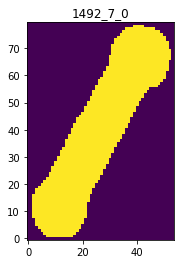

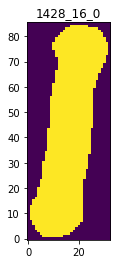

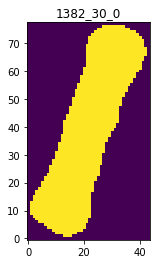

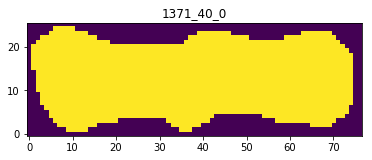

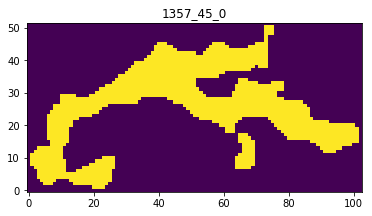

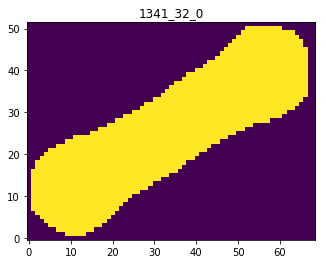

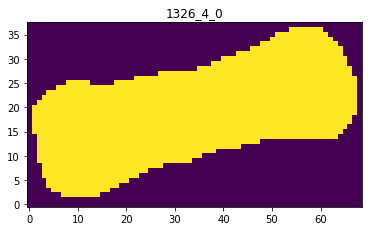

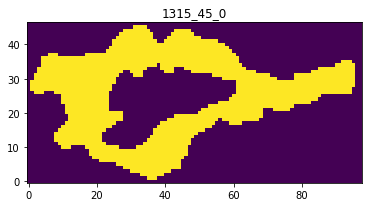

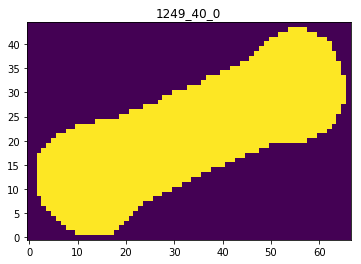

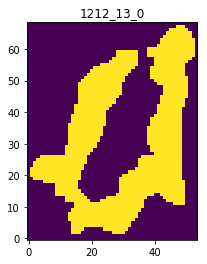

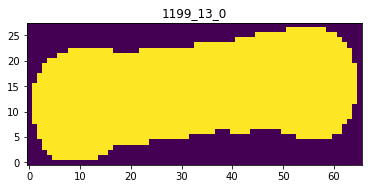

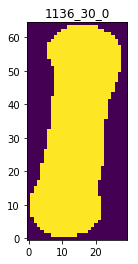

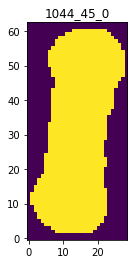

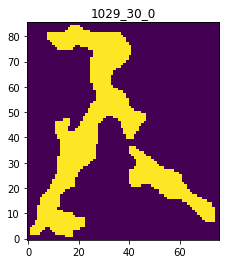

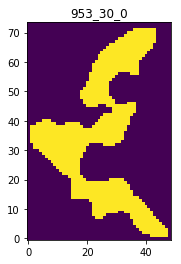

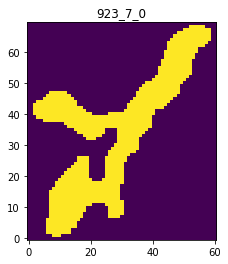

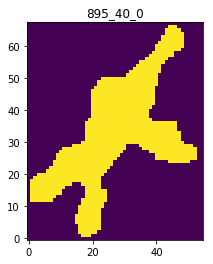

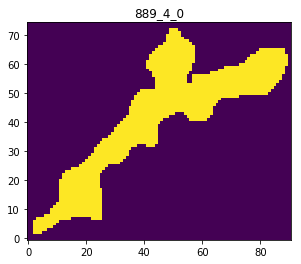

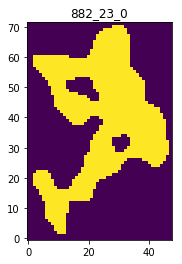

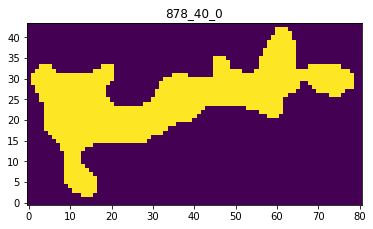

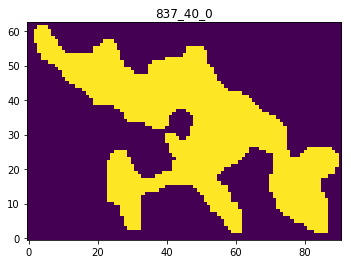

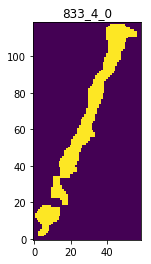

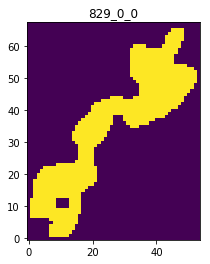

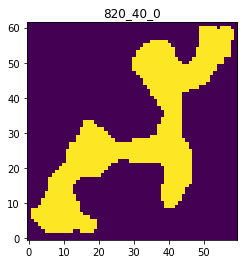

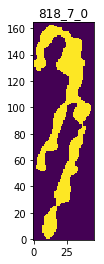

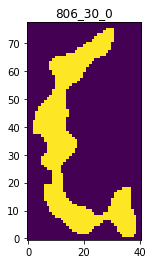

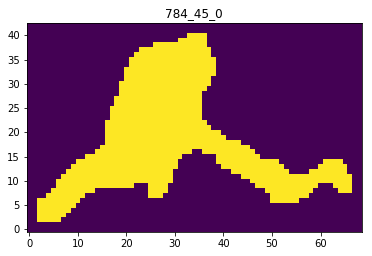

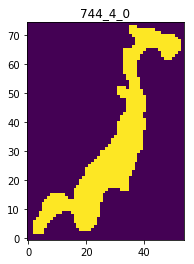

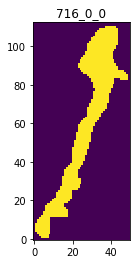

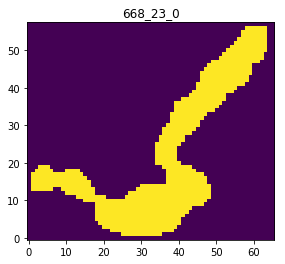

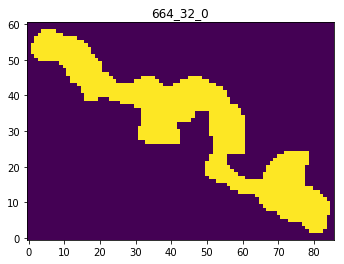

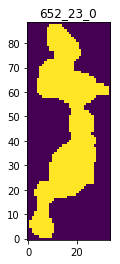

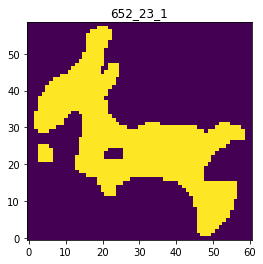

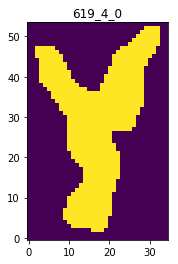

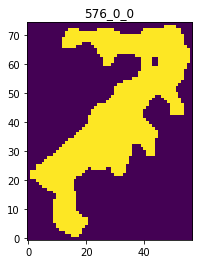

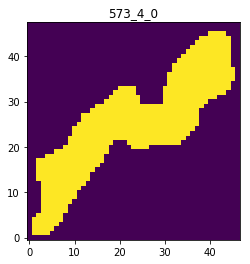

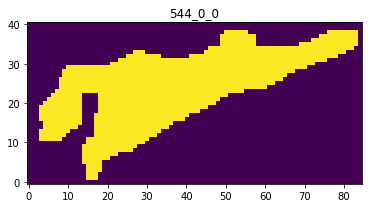

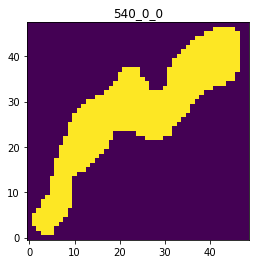

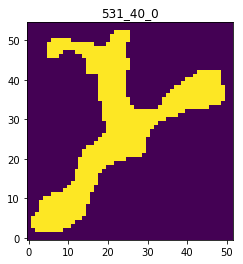

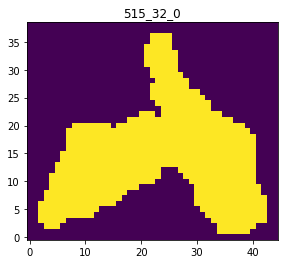

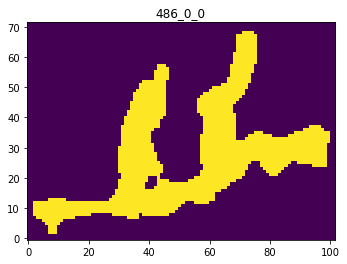

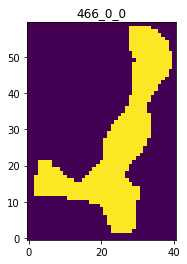

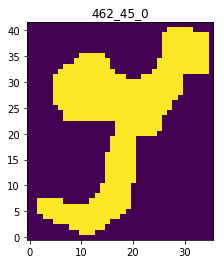

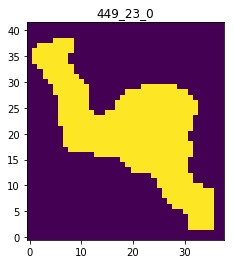

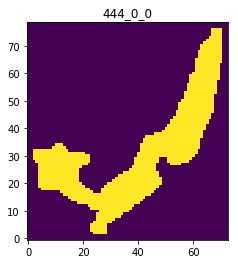

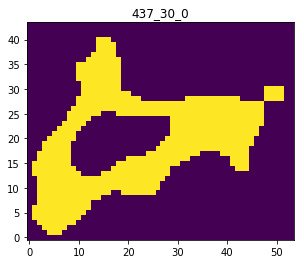

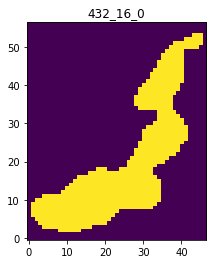

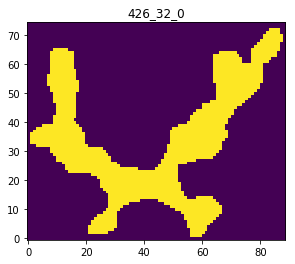

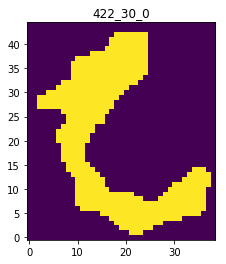

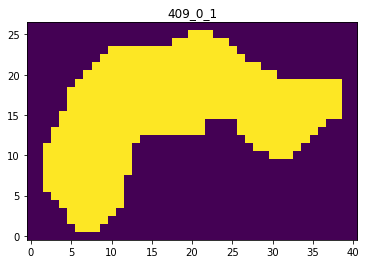

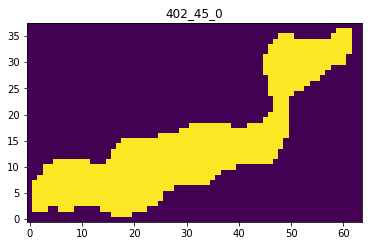

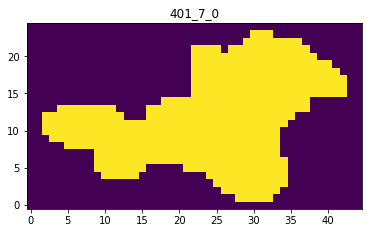

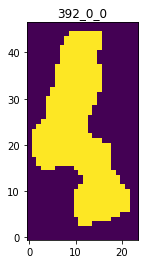

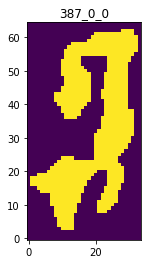

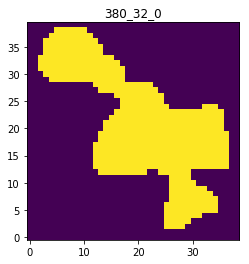

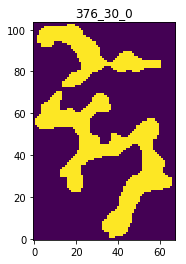

In [241]:
for k in struct_util.sorted_struct_dict_keys_by_area(trees.keys(), key_type='tree'):
    v = trees[k]
    if int(k.split('_')[1]) not in starts:
        continue
    fig, ax = plt.subplots()
    ax.imshow(v.root_node.mask, origin='lower')
    ax.set_title(k)
    fig.show()

In [244]:
injected_tree_keys = [
    '2183_0_0', '2154_16_0', '2063_45_0',
'1990_0_0', '1777_32_0', '1746_23_0',
'1624_4_0', '1590_13_0', '1524_23_0',
'1522_7_0', '1492_7_0', '1428_16_0',
'1382_30_0', '1371_40_0', '1341_32_0',
'1326_4_0', '1249_40_0', '1199_13_0',
'1136_30_0', '1044_45_0' 
]

In [245]:
injected_trees = {k:trees[k] for k in injected_tree_keys}

In [251]:
correct_length = dict()
for i, s in enumerate(starts):
    next_s = starts[i + 1] if i < len(starts) - 1 else 50
    correct_length[s] = next_s - s

In [253]:
for k, v in injected_trees.items():
    s = int(k.split('_')[1])
    if v.length != correct_length[s]:
        print(k)

In [258]:
trees['1371_40_0'].length

5

### finde nodes on all v slices

In [261]:
pickle.dump(nodes_dicts_clean, open('../../debug/avery_test_nodes/full_injected_nodes.p', 'wb'))